# Source:
Netflix Userbase Dataset   
https://www.kaggle.com/datasets/arnavsmayan/netflix-userbase-dataset https://www.kaggle.com/code/legendmortal07/netflix-customer-retension-prediction

# Import the necessary libraries

In [22]:
#Import all the necessary packages

#Pandasfor powerful data manipulation
import pandas as pd
#Numerical Python library that supports large multi-dimentional arryas and matrices
import numpy as np

#
import matplotlib.pylab as plt
#Python's visualization library
import seaborn as sns

#to scale the data using z-score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

#Silhouette score
from sklearn import metrics
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

from google.colab import files

# Preparation

In [23]:
import zipfile

uploaded = files.upload()
filename = "archive.zip"

def read_zip_file(filepath):
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        zip_ref.extractall()

# Please replace 'filepath' with the path to the zip file you want to read
read_zip_file('archive.zip')

Saving archive.zip to archive (2).zip


In [24]:
df = pd.read_csv('Netflix Userbase.csv')
df.head()

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month


# EDA

In [25]:
# Let's get a summary of the dataframe to view its structure and contents at a high level.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            2500 non-null   int64 
 1   Subscription Type  2500 non-null   object
 2   Monthly Revenue    2500 non-null   int64 
 3   Join Date          2500 non-null   object
 4   Last Payment Date  2500 non-null   object
 5   Country            2500 non-null   object
 6   Age                2500 non-null   int64 
 7   Gender             2500 non-null   object
 8   Device             2500 non-null   object
 9   Plan Duration      2500 non-null   object
dtypes: int64(3), object(7)
memory usage: 195.4+ KB


In [26]:
# Checking unique values in each column to prepare for data analysis and plan for necessary preprocessing steps.
df.nunique()

User ID              2500
Subscription Type       3
Monthly Revenue         6
Join Date             300
Last Payment Date      26
Country                10
Age                    26
Gender                  2
Device                  4
Plan Duration           1
dtype: int64

In [27]:
# Checking if there are any duplicated values. When duplicates are found, it's recommended to understand the cause and decide whether or not to remove the duplicates.
df[df.duplicated()]

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration


In [28]:
# Dropping columns that are not relevant for clustering.
df = df.drop(['User ID', 'Join Date', 'Last Payment Date', 'Plan Duration'], axis=1)

In [29]:
# Our data contains two types of variables: numerical and categorical.
# Let's separate them and store them in different lists.

# Creating a list of numerical columns
num_cols=['Monthly Revenue','Age']

# Creating a list of categorical variables
cat_cols= ['Subscription Type', 'Country', 'Gender', 'Device']

In [30]:
# Checking summary statistics of the numerical columns to understand their distribution and potential outliers.
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly Revenue,2500.0,12.5084,1.686851,10.0,11.0,12.0,14.0,15.0
Age,2500.0,38.7956,7.171778,26.0,32.0,39.0,45.0,51.0


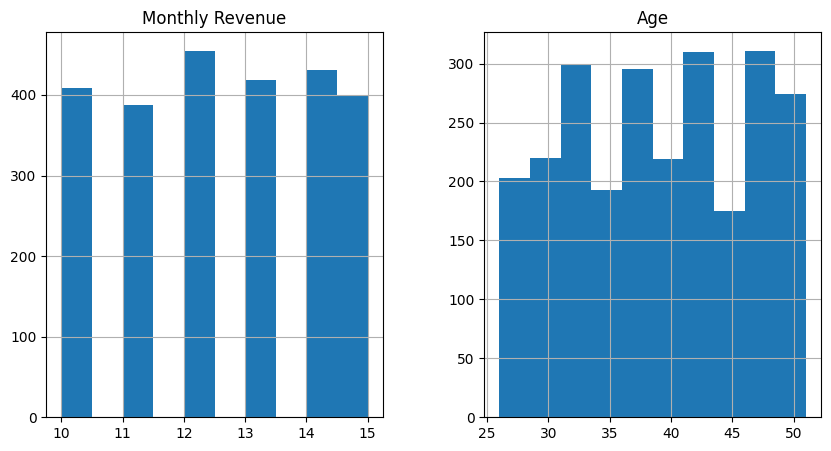

In [31]:
# [Attention] This is just an extra, and will be included if it is helpful for learners/readers.
# Creating histograms
df[num_cols].hist(figsize=(10,5))
plt.show()

In [32]:
# Printing the percentage of subcategories in each category.
for i in cat_cols:
    print(df[i].value_counts(normalize=True))
    print('*'*40)

Basic       0.3996
Standard    0.3072
Premium     0.2932
Name: Subscription Type, dtype: float64
****************************************
United States     0.1804
Spain             0.1804
Canada            0.1268
United Kingdom    0.0732
Australia         0.0732
Germany           0.0732
France            0.0732
Brazil            0.0732
Mexico            0.0732
Italy             0.0732
Name: Country, dtype: float64
****************************************
Female    0.5028
Male      0.4972
Name: Gender, dtype: float64
****************************************
Laptop        0.2544
Tablet        0.2532
Smartphone    0.2484
Smart TV      0.2440
Name: Device, dtype: float64
****************************************


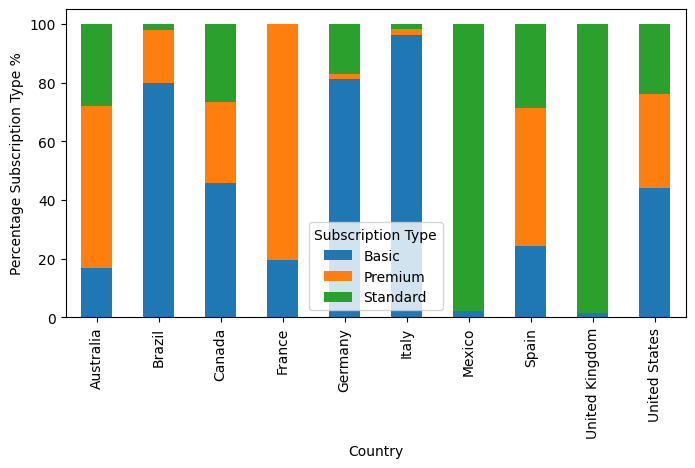

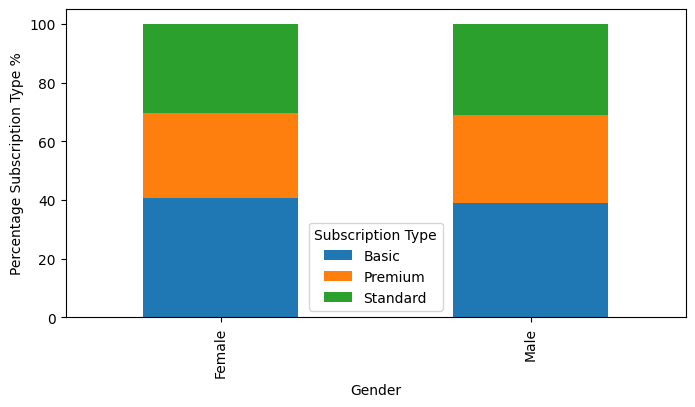

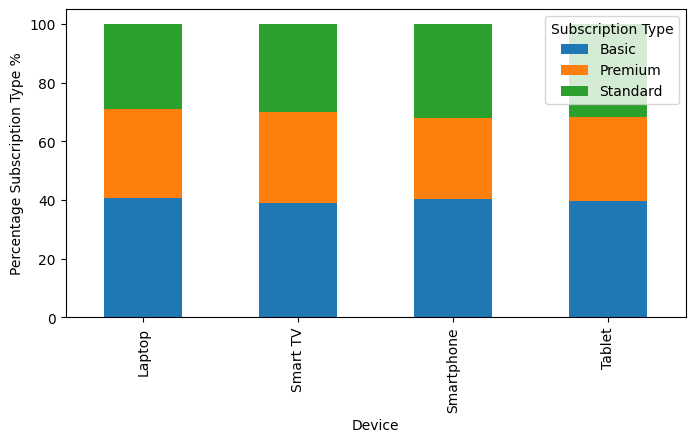

In [33]:
# Checking how Subscription Type is related to other categorical variables.
for i in cat_cols:
    if i!='Subscription Type':
        (pd.crosstab(df[i],df['Subscription Type'],normalize='index')*100).plot(kind='bar',figsize=(8,4),stacked=True)
        plt.ylabel('Percentage Subscription Type %')

In [34]:
# Calculating the mean of numerical variables grouped by Subscription Type
df.groupby(['Subscription Type'])[num_cols].mean()

,Monthly Revenue,Age
Subscription Type,,
Basic,12.481481,38.828829
Premium,12.590723,38.512960
Standard,12.464844,39.022135


<Axes: >

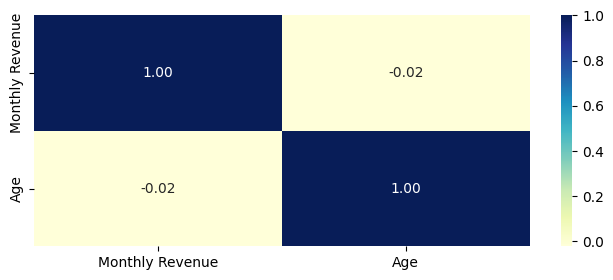

In [35]:
# Plotting the correlation between numerical variables
plt.figure(figsize=(8,3))
sns.heatmap(df[num_cols].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

### Observation:  
There is a negative correlation between age and monthly revenue.

### Description:   
Our dataset contains two types of values: numerical and categorical.  To calculate similarities or to feed the data into a machine learning model, we often need to convert categorical values into a numerical format.    
Two commonly used techniques for this conversion are Label Encoding and One-Hot Encoding.  

##### Label Encoding
is a simple and intuitive method that assigns a unique numerical label to each category within a feature.
This encoding method is preferred when the categorical variable has an inherent order or hierarchy, such as clothing sizes where 'S' (Small) could be represented as 0, 'M' (Medium) as 1, 'L' (Large) as 2, and 'XL' (Extra Large) as 3.
However, label encoding could misinterpret the numerical labels as ordinal data, hence we should carefully analyze the characteristics of our data.

##### One-Hot Encoding
on the other hand, is preferred when the categorical data has no inherent order, like countries or devices. In this method, each category for a feature is converted into a new binary feature (0 or 1), effectively spreading the categories out into multiple dimensions in the feature space. This prevents any notion of order or priority among the categories, which is beneficial for many machine learning models.   
However, one-hot encoding can significantly increase the dimensionality of the data, which might lead to the curse of dimensionality if not handled properly.  

Another tip for converting categorical values of no inherent order is using the get_dummies method, provided in the Pandas libraries in Python. This method is simpler and more handy for simple data analysis.

In [36]:
# Creating a list of columns to create dummy variables
to_get_dummies_for =  ['Subscription Type', 'Country', 'Gender', 'Device']

#creating dummy variables
df_converted= pd.get_dummies(data = df, columns= to_get_dummies_for, drop_first= False)

In [37]:
# Printing the first five rows in our dataframe to visually observe the converted values.
df_converted.head()

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_Mexico,Country_Spain,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet
0,10,28,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,15,35,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,12,42,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,12,51,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,10,33,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


### Description:  
After successfully running the 'get_dummies' method, the categorical columns are converted to numerical values.  
However, continuous features such as 'Age' and 'Revenue' remain in their original scale, and we should standardize them.  
K-Means is one of the machine learning algorithms that is sensitive to the scale of the features, as it measures the distance of each data point to determine similarities.  For this reason, we will apply the 'StandardScaler' in the following steps.

In [38]:
# Initializing the StandardScaler
scaler = StandardScaler()
# Selecting the numerical data from the dataframe
numeric_data = df_converted.select_dtypes(include = ['float64', 'int64'])
# Fitting the scaler to the numerical data and transforming it
scaled_data = scaler.fit_transform(numeric_data)

# Replacing the original numerical data in the dataframe with the scaled data
df_converted[numeric_data.columns] = scaled_data

# Note: Monthly revenue is understood as float, hense use select_dtypes 'float64'

In [39]:
scaled_data

array([[-1.48732831, -1.50559043],
       [ 1.47736693, -0.52934705],
       [-0.30145021,  0.44689633],
       ...,
       [-0.30145021, -0.11095703],
       [ 0.29148884,  1.28367636],
       [ 1.47736693, -0.52934705]])

In [40]:
df_converted.head()

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_Mexico,Country_Spain,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet
0,-1.487328,-1.505590,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
1,1.477367,-0.529347,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,-0.301450,0.446896,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,-0.301450,1.702066,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,-1.487328,-0.808274,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


### Tips:  
We have successfully converted all data types into numerical values, but it might be a little difficult to observe from the above table.  
Another helpful way to quickly visualize multi-dimensional data and spot patterns and trends is by using a 'heatmap'. The heatmap can help us understand how different variables in our dataset correlate with each other.

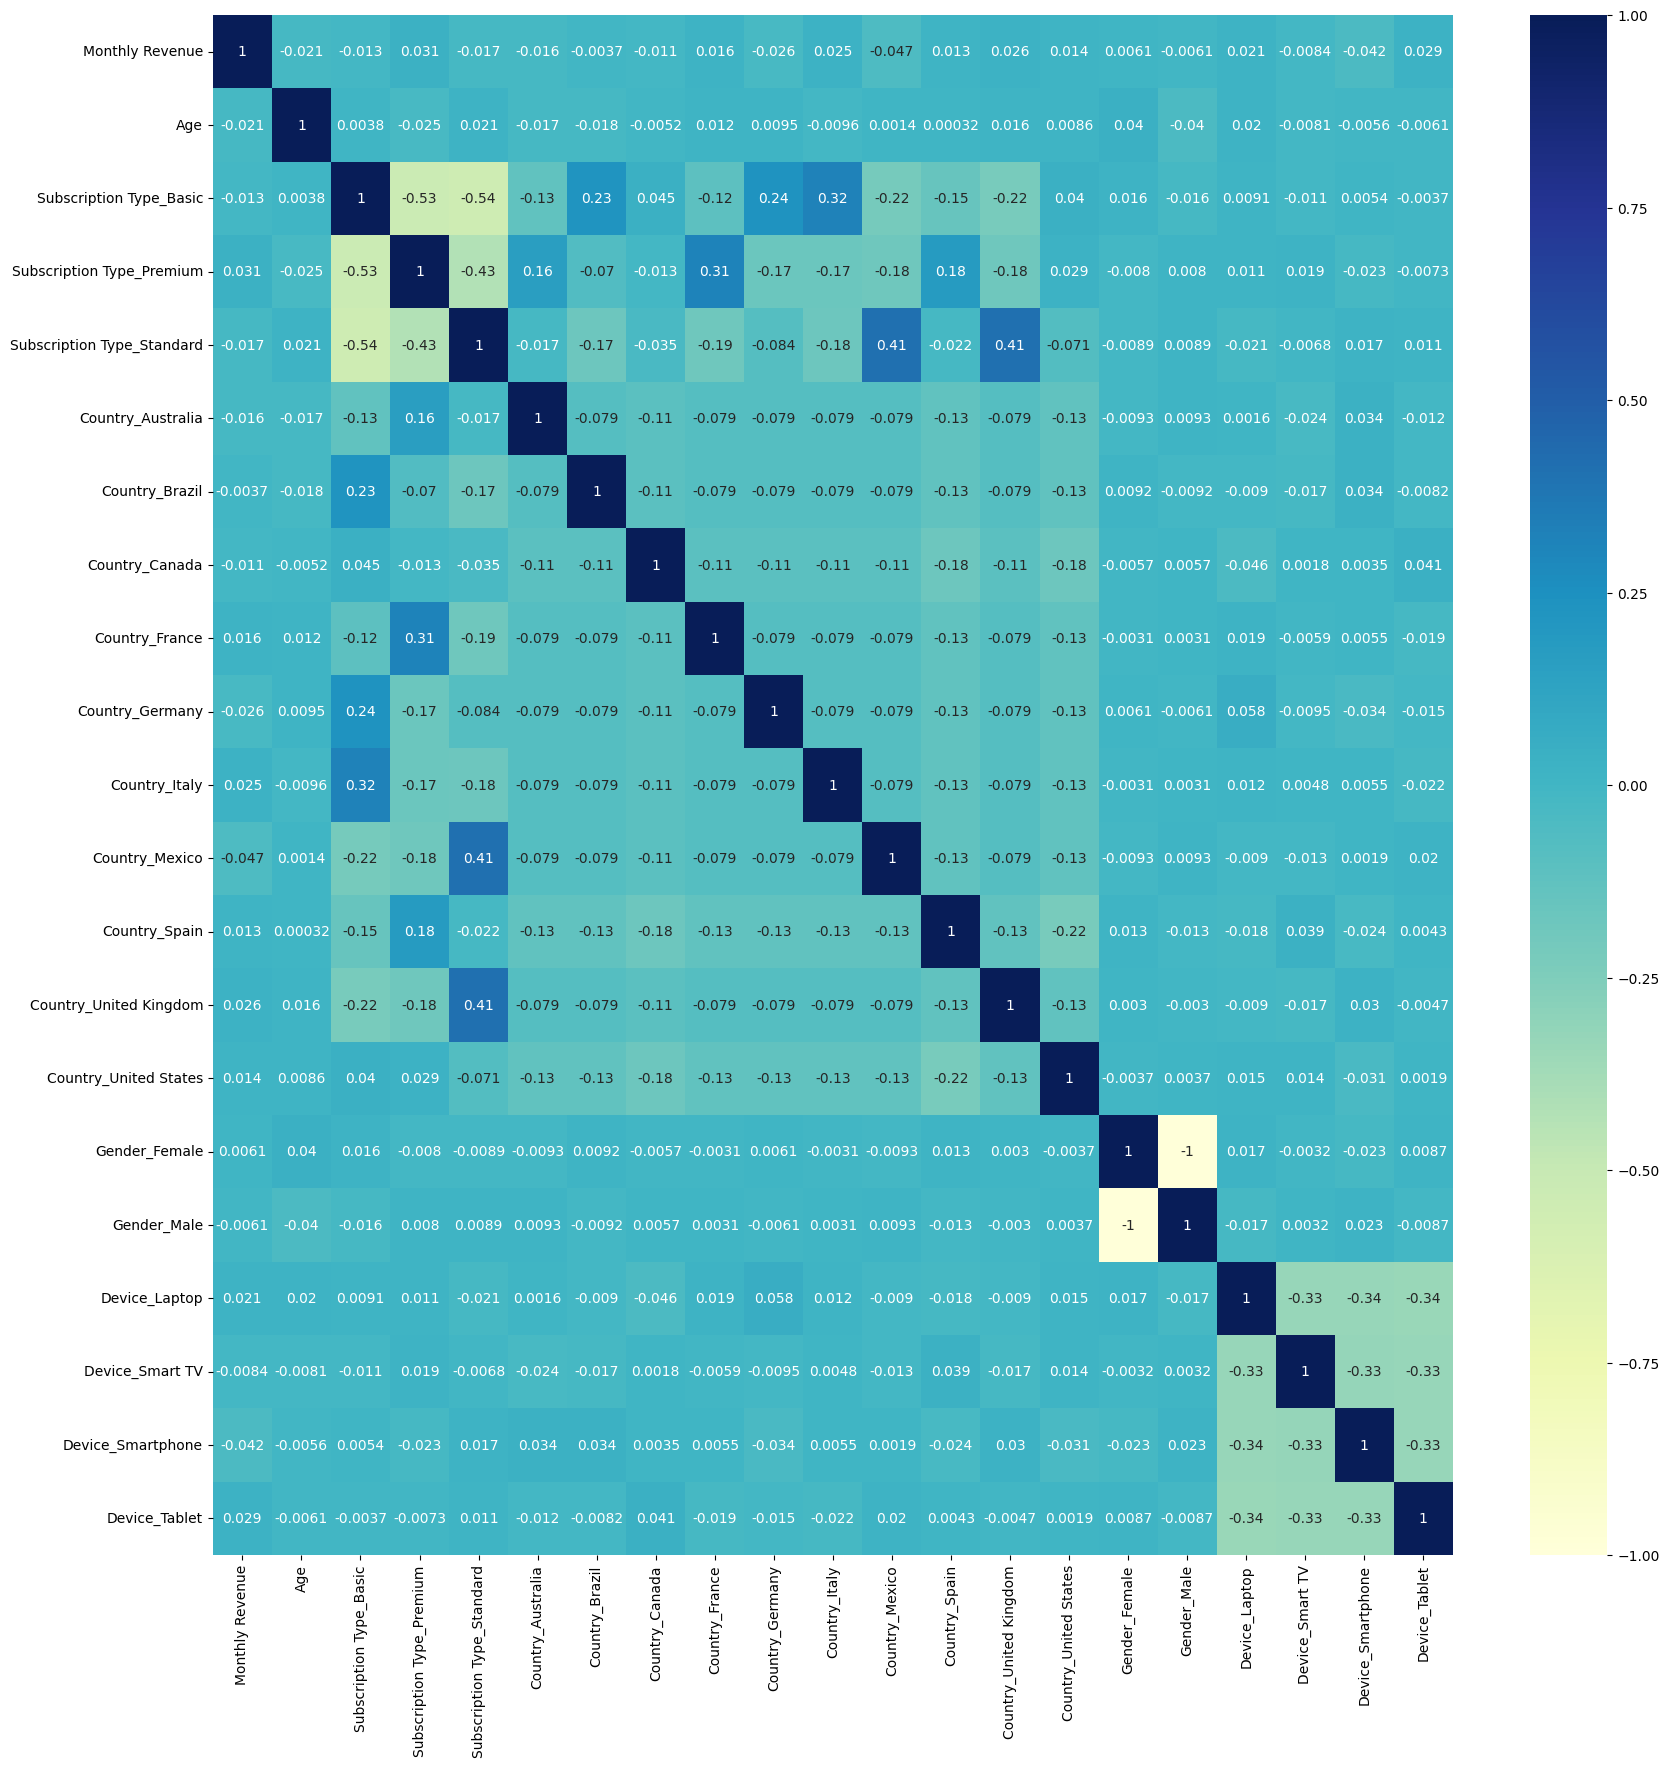

In [41]:
plt.figure(figsize  = (20,20))
sns.heatmap(df_converted.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Description:  
When applying K-means clustering, a critical step is determining the appropriate number of clusters, K. In real-world scenarios, choosing the optimal K value can be challenging, even after visualizing the data through boxplots, scatterplots, or heatmaps like ours. Furthermore, you may need to justify your choice of K to stakeholders or decision-makers.

One effective method for determining K is the Elbow Plot. This technique involves plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The “elbow” is indicative of the point where adding another cluster provides diminishing returns in terms of explained variation.

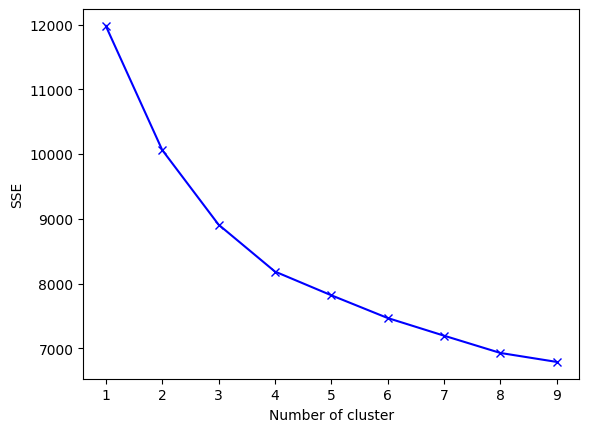

In [42]:
# The goal of K-means clustering is to minimize dissimilarities within clusters.
# This is achieved by minimizing the Sum of Squared Errors (SSE), which is the sum of the squared distances between each member of a cluster and its centroid.

# We start by initializing an empty dictionary to store the SSE for each number of clusters.
sse = {}

# We then iterate over different values of K (the number of clusters) and fit the scaled data to the algorithm.
# We use the inertia attribute from the clustering object and store the inertia value for that k.
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_converted)
    sse[k] = kmeans.inertia_

# Finally, we plot the SSE values against the number of clusters to create an Elbow plot.
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### Description:
The above elbow plot shows a gentle curve. However, after K=4, there doesn't seem to be much change.  
Therefore, we choose 4 as our initial number of clusters.

# K-Means

In [43]:
num_clusters = 4

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
df_converted['Cluster'] = kmeans.fit_predict(df_converted)

# Analyze clusters
cluster_stats = df_converted.groupby('Cluster').mean()
print(cluster_stats)

         Monthly Revenue       Age  Subscription Type_Basic  \
Cluster                                                       
0              -0.903328  0.885844                 0.417085   
1               0.823152  0.835401                 0.386018   
2               0.933672 -0.885806                 0.400000   
3              -0.844600 -0.848729                 0.396947   

         Subscription Type_Premium  Subscription Type_Standard  \
Cluster                                                          
0                         0.264657                    0.318258   
1                         0.299392                    0.314590   
2                         0.328814                    0.271186   
3                         0.280916                    0.322137   

         Country_Australia  Country_Brazil  Country_Canada  Country_France  \
Cluster                                                                      
0                 0.070352        0.078727        0.127303        0.

In [44]:
# Fitting the K-means model to our data stored in the 'df_converted' dataframe.
kmeans.fit(df_converted)
# Assigning each data point in the 'df_converted' dataframe to one of the K clusters by using the 'predict' method.
cluster = kmeans.predict(df_converted)
cluster

array([2, 0, 3, ..., 2, 1, 0], dtype=int32)

In [45]:
# Creating a copy to avoid modifying the original dataframe.
df_cluster = df_converted.copy()
# Adding the cluster assignments to our dataframe to store the results of our clustering analysis.
df_cluster['cluster']=cluster
df_cluster

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet,Cluster,cluster
0,-1.487328,-1.505590,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,3,2
1,1.477367,-0.529347,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,2,0
2,-0.301450,0.446896,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,3
3,-0.301450,1.702066,0,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,3
4,-1.487328,-0.808274,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.884428,-1.505590,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2,0
2496,1.477367,-0.808274,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2,0
2497,-0.301450,-0.110957,0,0,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,3,2
2498,0.291489,1.283676,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,1


In [46]:
df_results = pd.DataFrame()
df_cluster[df_cluster['cluster']==0].mean().tolist()

[0.9336719744808819,
 -0.8858058932304961,
 0.4,
 0.3288135593220339,
 0.2711864406779661,
 0.06610169491525424,
 0.08305084745762711,
 0.12542372881355932,
 0.07627118644067797,
 0.06949152542372881,
 0.07796610169491526,
 0.05254237288135593,
 0.19830508474576272,
 0.07288135593220339,
 0.17796610169491525,
 0.47966101694915253,
 0.5203389830508475,
 0.2576271186440678,
 0.2457627118644068,
 0.22033898305084745,
 0.27627118644067794,
 2.0,
 0.0]

In [47]:
# Using a for loop to go through each of the four clusters to calculate the mean of each feature of the data points, and store the calculated means in a new column, cluster 0, 1, 2, or 3.
for i in range(4):
    df_results[f'cluster {i}'] = df_cluster[df_cluster['cluster'] == i].mean().tolist()

df_cluster

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet,Cluster,cluster
0,-1.487328,-1.505590,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,3,2
1,1.477367,-0.529347,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,2,0
2,-0.301450,0.446896,0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,3
3,-0.301450,1.702066,0,0,1,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,3
4,-1.487328,-0.808274,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.884428,-1.505590,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2,0
2496,1.477367,-0.808274,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,2,0
2497,-0.301450,-0.110957,0,0,1,0,0,0,0,0,...,0,1,0,1,1,0,0,0,3,2
2498,0.291489,1.283676,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,1


In [48]:
# To have above data table be more visually understandable, adding index.
df_results = df_results.set_index(df_cluster.columns)
df_results

,cluster 0,cluster 1,cluster 2,cluster 3
Monthly Revenue,0.933672,0.823152,-0.844600,-0.903328
Age,-0.885806,0.835401,-0.848729,0.885844
Subscription Type_Basic,0.400000,0.386018,0.396947,0.417085
Subscription Type_Premium,0.328814,0.299392,0.280916,0.264657
Subscription Type_Standard,0.271186,0.314590,0.322137,0.318258
Country_Australia,0.066102,0.071429,0.083969,0.070352
Country_Brazil,0.083051,0.066869,0.065649,0.078727
Country_Canada,0.125424,0.123100,0.131298,0.127303
Country_France,0.076271,0.077508,0.073282,0.065327
Country_Germany,0.069492,0.072948,0.077863,0.072027


In [49]:
# Dropping the 'Cluster' and 'cluster' rows
df_results = df_results.drop(['Cluster', 'cluster'], errors='ignore')
df_results

,cluster 0,cluster 1,cluster 2,cluster 3
Monthly Revenue,0.933672,0.823152,-0.844600,-0.903328
Age,-0.885806,0.835401,-0.848729,0.885844
Subscription Type_Basic,0.400000,0.386018,0.396947,0.417085
Subscription Type_Premium,0.328814,0.299392,0.280916,0.264657
Subscription Type_Standard,0.271186,0.314590,0.322137,0.318258
Country_Australia,0.066102,0.071429,0.083969,0.070352
Country_Brazil,0.083051,0.066869,0.065649,0.078727
Country_Canada,0.125424,0.123100,0.131298,0.127303
Country_France,0.076271,0.077508,0.073282,0.065327
Country_Germany,0.069492,0.072948,0.077863,0.072027


### Observation:
In our example, we will first pay attention to the values that has the highest among each cluster and list them up like below:

[Cluster 0]  
-Monthly revenue: second lowest   
-Age: second youngest  
-Subscription Type: Standard  
-Countries: Australia, Canada, Germany, and Mexico  
-Gender: More female  
-Device: Smart TV    

[Cluster 1]  
-Monthly revenue: highest    
-Age: youngest    
-Subscription Type: Premium     
-Countries: Brazil, Italy, and Spain    
-Gender: More male  
-Device: Tablet     

[Cluster 2]   
-Monthly revenue: lowest  
-Age: olderst  
-Subscription Type: Basic     
-Countries: United Kingdom    
-Gender: More female  
-Device: Smartphone     

[Cluster 3]    
-Monthly revenue: second highest  
-Age: second highest  
-Subscription Type: amost equally distributed   
-Countries: Germany, United States    
-Gender: More female  
-Device: Laptop and Smart TV    
  
Now you see how the K-means clustering method can help us observe the multi-dimensional data and find unseen characteristics from our dataset.   Based on the results, we could formulate our marketing plan, choose an advertisement method, or decide how to run a campaign.   Also, we could study what channels people in each cluster watch, then be able to build a more welcoming recommendation system.

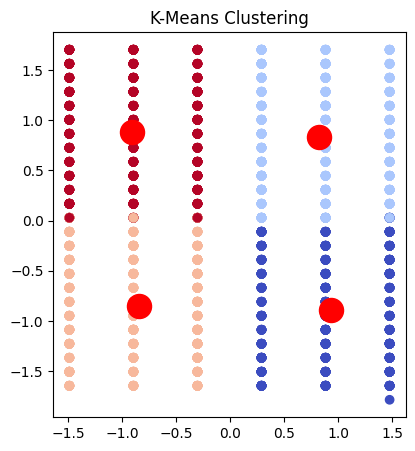

In [50]:
# Plotting just for visualization, but will remove these codes if not necessary.
labels = kmeans.labels_
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.scatter(scaled_data[:,0], scaled_data[:,1], c=labels, cmap='coolwarm')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='red')
plt.title('K-Means Clustering')

plt.show()


In [53]:
score = silhouette_score(df_converted, kmeans.fit_predict(df_converted))
print(score)

0.19109710612699796


# K-Medoids

In [ ]:
pip install scikit-learn-extra

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
#Creating an instance of the K-Medoids class, setting the number of cluster as 4.
# We also set the random_state to ensure the results are reproducible.
kmedo = KMedoids(n_clusters = 4, random_state=0)
# Applying the K-Medoids clustering to the df_converted dataset.
kmedo.fit(df_converted)
# First predicting the closest datapoint in each df_converted dataset by using the already fitted model.
# Then adding these predictions as a new column kmedoLabels to the df_converted dataframe.
df_converted['kmedoLabels'] = kmedo.predict(df_converted)

In [ ]:
df_converted.kmedoLabels.value_counts()

2    763
0    597
3    592
1    548
Name: kmedoLabels, dtype: int64

In [ ]:
# Calculating mean and median of all features of each cluster to understand the central tendency of each cluster.
# First making a copy of the original dataset before moving forward by creating a new variable: original_features.
original_features = df_converted.copy()
mean = df_converted.groupby('kmedoLabels').mean()
median = df_converted.groupby('kmedoLabels').median()

In [ ]:
df_kmedoids = pd.concat([mean, median], axis=0)
df_kmedoids

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_Spain,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet,Cluster
kmedoLabels,,,,,,,,,,,,,,,,,,,,,
0,-0.876512,-0.823458,0.447236,0.231156,0.321608,0.075377,0.072027,0.128978,0.070352,0.085427,...,0.130653,0.067002,0.206030,0.440536,0.559464,0.241206,0.261307,0.298157,0.199330,2.983250
1,0.801113,-0.942393,0.251825,0.468978,0.279197,0.078467,0.069343,0.124088,0.094891,0.045620,...,0.286496,0.072993,0.111314,0.443431,0.556569,0.222628,0.239051,0.145985,0.392336,2.069343
2,0.064571,0.846277,0.431193,0.259502,0.309305,0.068152,0.081258,0.121887,0.070773,0.083879,...,0.154653,0.074705,0.196592,0.868938,0.131062,0.408912,0.239843,0.133683,0.217562,0.621232
3,0.059121,0.612038,0.447635,0.236486,0.315878,0.072635,0.067568,0.133446,0.059122,0.072635,...,0.165541,0.077703,0.197635,0.148649,0.851351,0.097973,0.236486,0.440878,0.224662,0.699324
0,-0.894389,-0.808274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
1,0.884428,-1.087200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
2,0.291489,1.004750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
3,0.291489,0.586360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
# Replacing the index to easily understand each cluster's mean and median.
df_kmedoids.index = ['cluster_0 Mean', 'cluster_1 Mean', 'cluster_2 Mean', 'cluster_3 Mean', 'cluster_0 Median', 'cluster_1 Median', 'cluster_2 Median', 'cluster_3 Median']
# For our visualization purpose, transposing swaps the rows and columns of the DataFrame.
df_kmedoids.T

,cluster_0 Mean,cluster_1 Mean,cluster_2 Mean,cluster_3 Mean,cluster_0 Median,cluster_1 Median,cluster_2 Median,cluster_3 Median
Monthly Revenue,-0.876512,0.801113,0.064571,0.059121,-0.894389,0.884428,0.291489,0.291489
Age,-0.823458,-0.942393,0.846277,0.612038,-0.808274,-1.087200,1.004750,0.586360
Subscription Type_Basic,0.447236,0.251825,0.431193,0.447635,0.000000,0.000000,0.000000,0.000000
Subscription Type_Premium,0.231156,0.468978,0.259502,0.236486,0.000000,0.000000,0.000000,0.000000
Subscription Type_Standard,0.321608,0.279197,0.309305,0.315878,0.000000,0.000000,0.000000,0.000000
Country_Australia,0.075377,0.078467,0.068152,0.072635,0.000000,0.000000,0.000000,0.000000
Country_Brazil,0.072027,0.069343,0.081258,0.067568,0.000000,0.000000,0.000000,0.000000
Country_Canada,0.128978,0.124088,0.121887,0.133446,0.000000,0.000000,0.000000,0.000000
Country_France,0.070352,0.094891,0.070773,0.059122,0.000000,0.000000,0.000000,0.000000
Country_Germany,0.085427,0.045620,0.083879,0.072635,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Creating an instance of the K-Medoids class with 4 clusters, using Euclidean distance to calculate the distance between data points, and applying PAM (Partitioning Around Medoids) parameter as K-Medoids methods.
kmedoids = KMedoids(n_clusters=4, metric='euclidean', method='pam')
# Fit and predict
kmedoids.fit(df_converted)
labels = kmedoids.predict(df_converted)

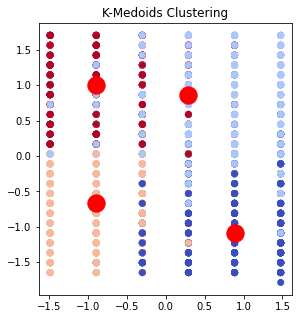

In [ ]:
labels = kmedoids.labels_
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.scatter(scaled_data[:,0], scaled_data[:,1], c=labels, cmap='coolwarm')
plt.scatter(kmedoids.cluster_centers_[:,0], kmedoids.cluster_centers_[:,1], s=300, c='red')
plt.title('K-Medoids Clustering')

plt.show()


# Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

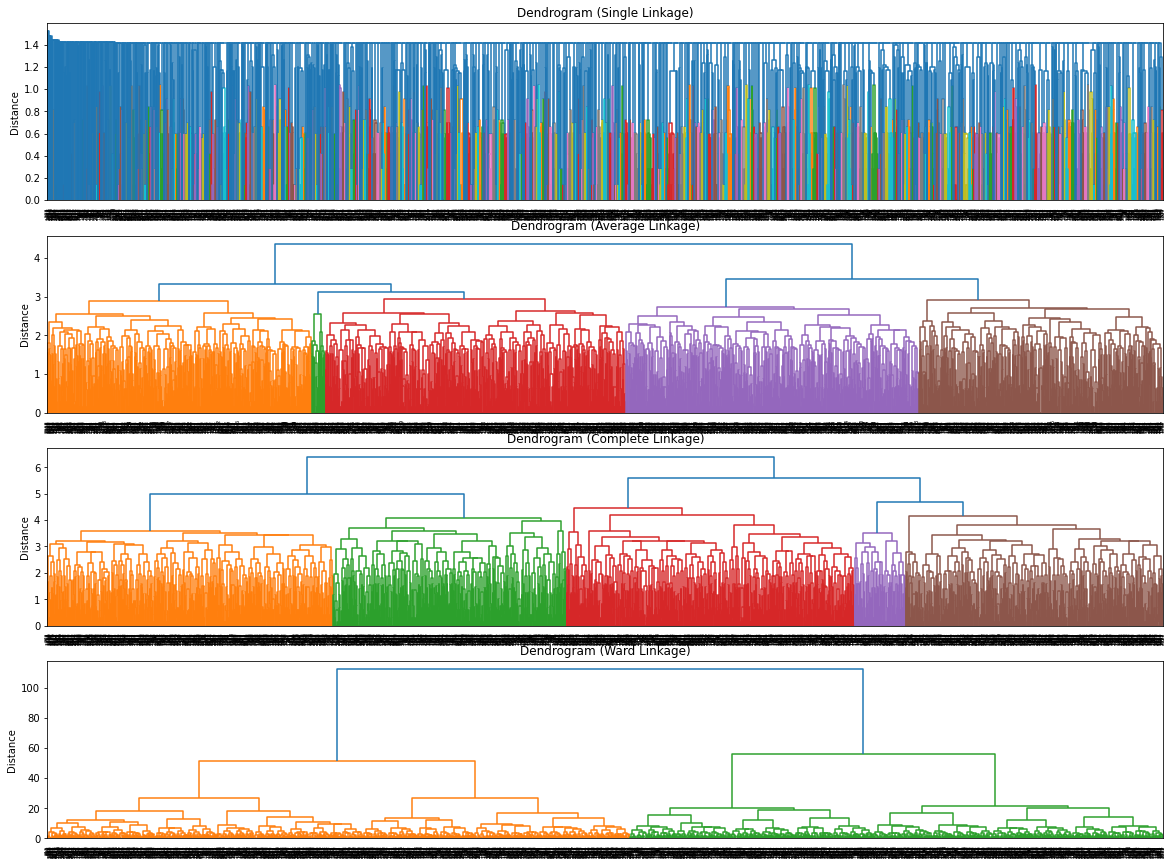

In [ ]:
# List of all linkage methods to check
methods = ['single',
           'average',
           'complete',
           'ward']

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(20, 15))

# Enumerate through the list of all methods above, get linkage and plot dendrogram
for i, method in enumerate(methods):
    Z = linkage(df_converted, metric='euclidean', method=method)
    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    axs[i].set_ylabel('Distance')

# Gaussian Mixture Clustering

In [ ]:
from sklearn.mixture import GaussianMixture

# Set the number of clusters. Here, we use 4, same as KMeans.
num_clusters = 4

# Create an instance of GMM.
gmm = GaussianMixture(n_components=num_clusters, random_state=0)

# Fit the GMM to the data.
gmm.fit(df_converted)

# Assign each data point to a cluster.
df_converted['GMM_Cluster'] = gmm.predict(df_converted)

# Analyze the statistics of the clusters.
gmm_cluster_stats = df_converted.groupby('GMM_Cluster').mean()

# Calculate the mean values of each cluster and visualize the results.
df_gmm_results = pd.DataFrame()
for i in range(num_clusters):
    df_gmm_results[f'GMM_cluster {i}'] = df_converted[df_converted['GMM_Cluster'] == i].mean()
print(df_gmm_results)


                            GMM_cluster 0  GMM_cluster 1  GMM_cluster 2  \
Monthly Revenue                  0.944678      -0.026520      -0.846475   
Age                             -0.824919       0.871320      -0.914867   
Subscription Type_Basic          0.380645       0.410612       0.417508   
Subscription Type_Premium        0.353226       0.269388       0.289562   
Subscription Type_Standard       0.266129       0.320000       0.292929   
Country_Australia                0.067742       0.070204       0.077441   
Country_Brazil                   0.079032       0.074286       0.074074   
Country_Canada                   0.125806       0.124898       0.134680   
Country_France                   0.079032       0.070204       0.067340   
Country_Germany                  0.066129       0.074286       0.077441   
Country_Italy                    0.074194       0.074286       0.080808   
Country_Mexico                   0.051613       0.076735       0.070707   
Country_Spain            

In [ ]:
# Create a copy of the DataFrame
gmm_table = df_gmm_results.copy()

# Drop the specified columns from the copy
gmm_table = gmm_table.drop(['Cluster', 'kmedoLabels', 'GMM_Cluster'], axis=0)
gmm_table



,GMM_cluster 0,GMM_cluster 1,GMM_cluster 2,GMM_cluster 3
Monthly Revenue,0.944678,-0.026520,-0.846475,-0.843045
Age,-0.824919,0.871320,-0.914867,-0.793860
Subscription Type_Basic,0.380645,0.410612,0.417508,0.379888
Subscription Type_Premium,0.353226,0.269388,0.289562,0.273743
Subscription Type_Standard,0.266129,0.320000,0.292929,0.346369
Country_Australia,0.067742,0.070204,0.077441,0.089385
Country_Brazil,0.079032,0.074286,0.074074,0.058659
Country_Canada,0.125806,0.124898,0.134680,0.128492
Country_France,0.079032,0.070204,0.067340,0.078212
Country_Germany,0.066129,0.074286,0.077441,0.078212


In [ ]:
# Calculate the size of each cluster
cluster_sizes = df_converted['GMM_Cluster'].value_counts()

# Print the size of each cluster
print(cluster_sizes)


1    1225
0     620
3     358
2     297
Name: GMM_Cluster, dtype: int64


In [ ]:
# Calculate the size of K-means cluster for comparison
cluster_sizes = df_converted['Cluster'].value_counts()

# Print the size of each cluster
print(cluster_sizes)

1    658
3    655
0    597
2    590
Name: Cluster, dtype: int64


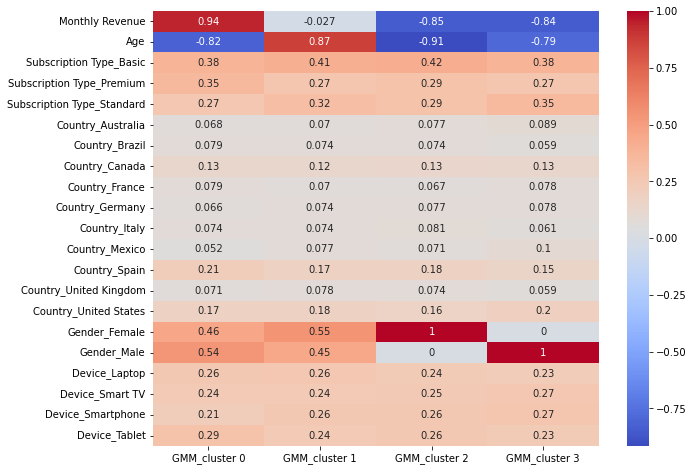

In [ ]:
# Giving a visual representation of the result.
#import matplotlib.pyplot as plt
#import seaborn as sns

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(gmm_table, cmap='coolwarm', annot=True)

# Show the plot
plt.show()


# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit and predict clusters
df_converted['DBSCAN_Cluster'] = dbscan.fit_predict(df_converted)

# Analyze clusters
dbscan_cluster= df_converted.groupby('DBSCAN_Cluster').mean()
print(dbscan_cluster)


                Monthly Revenue       Age  Subscription Type_Basic  \
DBSCAN_Cluster                                                       
-1                    -0.003533 -0.001735                 0.399919   
 0                    -1.487328  0.307433                 1.000000   
 1                     1.477367 -1.389371                 0.000000   
 2                    -0.301450  1.032642                 0.000000   
 3                     0.884428  0.670038                 0.000000   
 4                     1.477367  0.921072                 1.000000   
 5                    -1.487328 -0.278313                 0.000000   
 6                    -0.301450 -0.891952                 1.000000   
 7                     1.477367  0.697930                 0.000000   

                Subscription Type_Premium  Subscription Type_Standard  \
DBSCAN_Cluster                                                          
-1                               0.291701                    0.308381   
 0        

In [ ]:
# Create a copy of the DataFrame
dbscan_copy = dbscan_cluster.copy()

# Drop the specified columns from the copy
dbscan_copy = dbscan_copy.drop(['Cluster', 'kmedoLabels', 'GMM_Cluster'], axis=1)
dbscan_copy

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_Mexico,Country_Spain,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,
-1,-0.003533,-0.001735,0.399919,0.291701,0.308381,0.074451,0.074451,0.128967,0.074451,0.07201,...,0.072417,0.179007,0.072417,0.179414,0.500407,0.499593,0.252238,0.24166,0.25061,0.255492
0,-1.487328,0.307433,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.00000,0.000000
1,1.477367,-1.389371,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.00000,0.000000
2,-0.301450,1.032642,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.00000,0.000000
3,0.884428,0.670038,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.00000,0.000000
4,1.477367,0.921072,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,0.00000,0.000000
5,-1.487328,-0.278313,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.00000,0.000000
6,-0.301450,-0.891952,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.00000,0.00000,0.000000
7,1.477367,0.697930,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.00000,1.000000


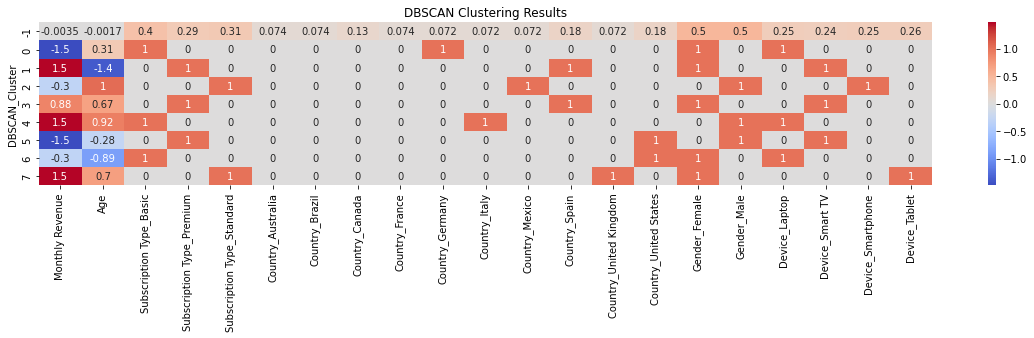

In [ ]:
plt.figure(figsize=(20, 3))
sns.heatmap(dbscan_copy, annot=True, cmap='coolwarm')
plt.title('DBSCAN Clustering Results')
plt.show()


In [ ]:
# Calculate the size of each DBSCAN cluster
cluster_sizes = df_converted['DBSCAN_Cluster'].value_counts()

# Print the size of each cluster
print(cluster_sizes)

-1    2458
 1       6
 0       6
 2       5
 7       5
 6       5
 3       5
 4       5
 5       5
Name: DBSCAN_Cluster, dtype: int64


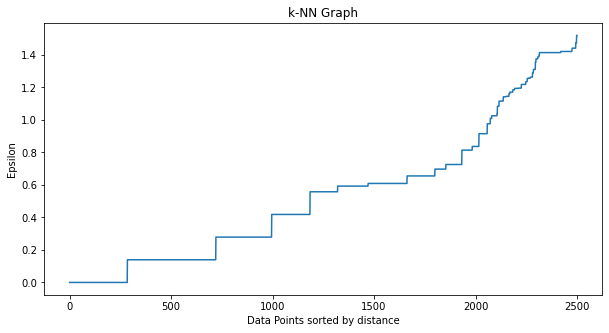

In [ ]:
from sklearn.neighbors import NearestNeighbors

min_samples=5

# Compute the nearest neighbors
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
nearest_neighbors.fit(df_converted)
distances, indices = nearest_neighbors.kneighbors(df_converted)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot the k-distance graph
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('k-NN Graph')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()


In [ ]:
# Initialize DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)

# Fit and predict clusters
df_converted['DBSCAN_Cluster'] = dbscan.fit_predict(df_converted)

# Analyze clusters
dbscan_afterkNN= df_converted.groupby('DBSCAN_Cluster').mean()
print(dbscan_afterkNN)


                Monthly Revenue       Age  Subscription Type_Basic  \
DBSCAN_Cluster                                                       
-1                    -0.005304  0.001844                 0.381808   
 0                    -0.301450  1.032642                 0.000000   
 1                     1.477367 -1.389371                 0.000000   
 2                    -0.968507 -0.773408                 1.000000   
 3                    -1.487328  0.307433                 1.000000   
...                         ...       ...                      ...   
 106                  -0.657214  0.223755                 0.000000   
 107                   1.240191 -1.366127                 0.000000   
 108                  -1.131565 -0.529347                 0.000000   
 109                  -0.775801 -0.836166                 1.000000   
 110                  -1.012977  1.144213                 0.000000   

                Subscription Type_Premium  Subscription Type_Standard  \
DBSCAN_Cluster  

In [ ]:
# Create a copy of the DataFrame
dbscan_afterkNN = dbscan_afterkNN.copy()

# Drop the specified columns from the copy
dbscan_afterkNN = dbscan_afterkNN.drop(['Cluster', 'kmedoLabels', 'GMM_Cluster'], axis=1)
dbscan_afterkNN

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_Mexico,Country_Spain,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,
-1,-0.005304,0.001844,0.381808,0.294118,0.324074,0.09695,0.086057,0.127996,0.080065,0.066449,...,0.064815,0.166667,0.063181,0.175381,0.497821,0.502179,0.252723,0.230937,0.264706,0.251634
0,-0.301450,1.032642,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
1,1.477367,-1.389371,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,-0.968507,-0.773408,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
3,-1.487328,0.307433,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-0.657214,0.223755,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
107,1.240191,-1.366127,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
108,-1.131565,-0.529347,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000


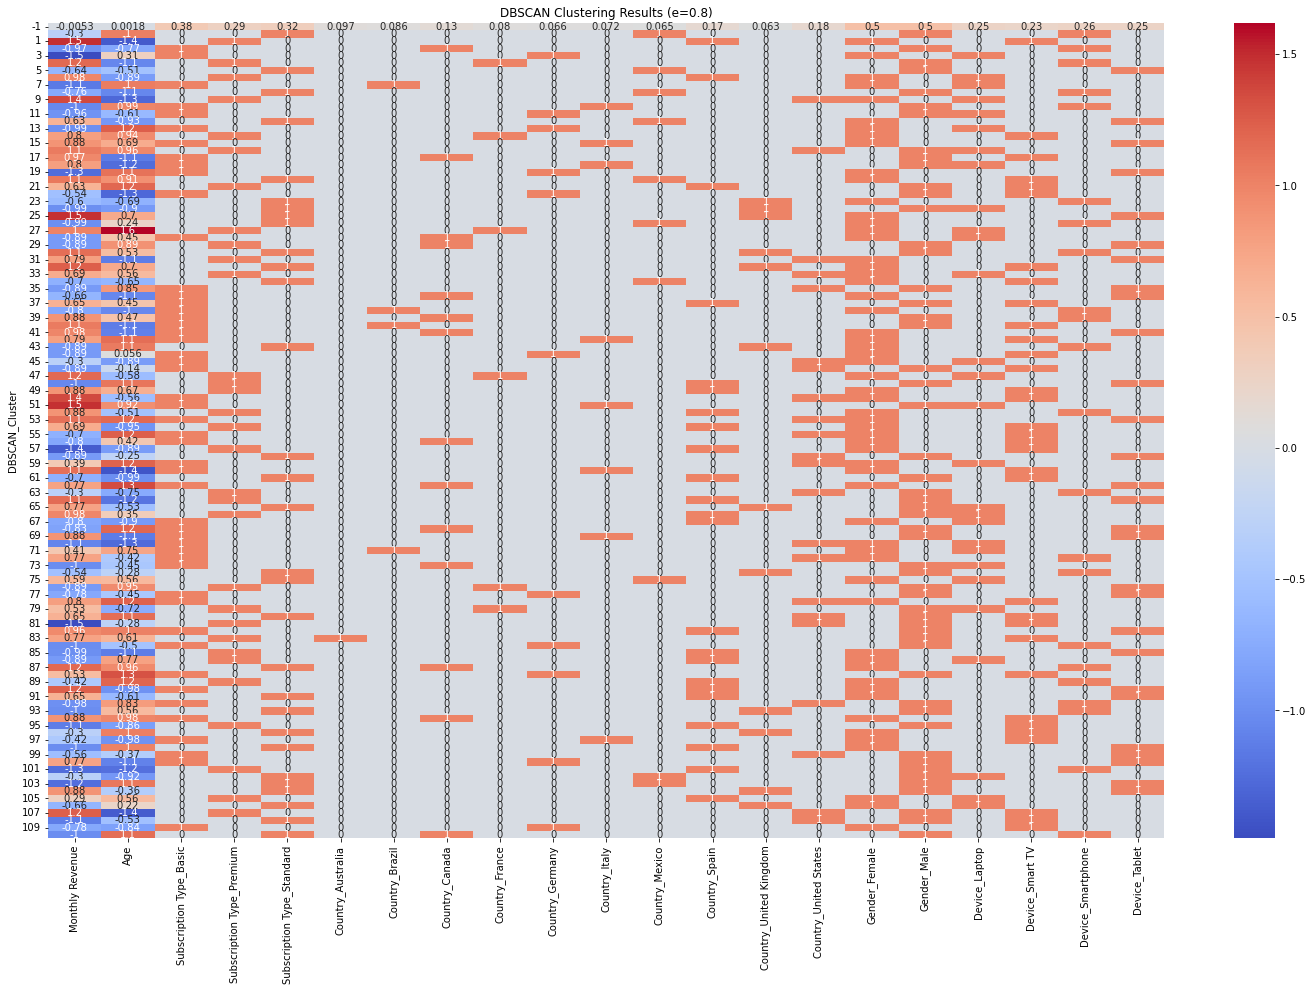

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 15))
sns.heatmap(dbscan_afterkNN, annot=True, cmap='coolwarm')
plt.title('DBSCAN Clustering Results (e=0.8)')
plt.show()

In [ ]:
# Calculate the size of each DBSCAN cluster
cluster_sizes = df_converted['DBSCAN_Cluster'].value_counts()

# Print the size of each cluster
print(cluster_sizes)

-1      1836
 6        12
 54        9
 11        9
 8         9
        ... 
 109       5
 25        5
 88        5
 73        5
 105       5
Name: DBSCAN_Cluster, Length: 112, dtype: int64


In [ ]:
# Define DBSCAN models with different parameters
dbscan_models = {
    'DBSCAN_eps_0.5': DBSCAN(eps=0.5, min_samples=5),
    'DBSCAN_eps_0.8': DBSCAN(eps=0.8, min_samples=5)
}

# Store results
dbscan_results = {}

# Fit models and calculate metrics
for name, model in dbscan_models.items():
    model.fit(df_converted)
    labels = model.labels_
    dbscan_results[name] = metrics.silhouette_score(df_converted, labels)

# Print results
for name, score in dbscan_results.items():
    print(f"\n{name} Silhouette Score: {score}")



DBSCAN_eps_0.5 Silhouette Score: -0.7582008519951515

DBSCAN_eps_0.8 Silhouette Score: 0.1020286324166116


In [ ]:
# Create a dictionaly to define models
models = {
    'KMeans': KMeans(n_clusters=4, random_state=0),
    'KMedoids': KMedoids(n_clusters=4, metric='euclidean', method='pam', random_state=0),
    'Hierarchical': AgglomerativeClustering(n_clusters=4, linkage='ward'),
    'GaussianMixture': GaussianMixture(n_components=4, random_state=0),
    'DBSCAN': DBSCAN(eps=0.8, min_samples=5)

}

# Create a dictionary to store the results
results = {}

# Fit models and calculate metrics
for name, model in models.items():
    model.fit(df_converted)
    labels = model.predict(df_converted) if name == 'GaussianMixture' else model.labels_
    results[name] = metrics.silhouette_score(df_converted, labels)

# Print results
for name, score in results.items():
    print(f"\n{name} Silhouette Score: {score}")



KMeans Silhouette Score: 0.7698724498044935

KMedoids Silhouette Score: 0.7780589864718633

Hierarchical Silhouette Score: 0.7677584235322338

GaussianMixture Silhouette Score: -0.2248229255697769

DBSCAN Silhouette Score: 0.1020286324166116


# - End of Unsupervised Machine Learning -